# **Analisis Sentimen Ulasan Pengguna pada Aplikasi Clash of Clans di Google Play Store**

## Import Library

In [1]:
import pandas as pd  # Pandas untuk manipulasi dan analisis data, terutama data tabular (DataFrame)
import numpy as np  # Numpy untuk komputasi numerik dan operasi array/matriks
import matplotlib.pyplot as plt  # Matplotlib untuk membuat visualisasi seperti grafik dan plot
import seaborn as sns  # Seaborn untuk visualisasi data statistik dengan tampilan yang lebih estetik
import re  # Modul regex untuk pencarian dan manipulasi teks berbasis pola
import string  # Modul yang berisi konstanta string seperti huruf dan tanda baca
import requests  # Untuk melakukan HTTP request (misal: mengambil data dari API atau web)
import nltk  # Natural Language Toolkit, pustaka NLP untuk bahasa Inggris dan multibahasa
from nltk.tokenize import word_tokenize  # Untuk memecah kalimat menjadi kata-kata (tokenisasi)
from nltk.corpus import stopwords  # Menyediakan kumpulan kata-kata umum yang bisa dihapus (stopwords)
nltk.download('punkt_tab')  # Mengunduh tokenizer berbasis tanda baca
nltk.download('stopwords')  # Mengunduh daftar stopwords untuk berbagai bahasa

# Install library Sastrawi (khusus Bahasa Indonesia)
!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Untuk stemming: mengubah kata ke bentuk dasar (akar kata)
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Untuk menghapus kata-kata umum (stopwords) dalam Bahasa Indonesia
from wordcloud import WordCloud  # Untuk membuat visualisasi word cloud dari teks
import random  # Untuk operasi randomisasi seperti sampling, shuffle, dll.

# Modul dari scikit-learn untuk preprocessing dan modeling
from sklearn.model_selection import train_test_split  # Membagi dataset ke dalam data train dan test
from sklearn.preprocessing import LabelEncoder  # Mengubah label kategorik menjadi angka
from sklearn.feature_extraction.text import TfidfVectorizer  # Mengubah teks menjadi fitur berbasis TF-IDF
from sklearn.feature_extraction.text import CountVectorizer  # Mengubah teks menjadi fitur berbasis frekuensi kata
from sklearn.metrics import classification_report, accuracy_score  # Untuk evaluasi performa model klasifikasi
from sklearn.ensemble import RandomForestClassifier  # Model ensemble berbasis decision tree (Random Forest)
from sklearn.naive_bayes import MultinomialNB  # Model klasifikasi Naive Bayes, cocok untuk teks

from imblearn.over_sampling import SMOTE  # Synthetic Minority Oversampling Technique, untuk menangani data tidak seimbang
import pickle  # Untuk menyimpan dan memuat model atau objek Python dalam format binary (serialization)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.7 MB/s eta 0:00:00


## Loading Dataset

In [2]:
# Load dataset
df_loaded = pd.read_csv('https://github.com/syahelrusfi21/Analisis-Sentimen-Ulasan-Pengguna-pada-Aplikasi-Clash-of-Clans-di-Google-Play-Store/raw/master/review_clashofclans.csv')
print('Dimensi data:', df_loaded.shape)
df_loaded.head()

Dimensi data: (12000, 11)


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,6cedfaca-247b-4209-a285-39d04ab59e63,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Clash of clans sekarang sering gangguan atau l...,2,2076,16.654.16,2024-12-14 12:45:20,NaN,NaN,16.654.16
1,a523cbd6-02f6-426a-ae8c-1e9151279d3b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Buat kalian yang sering force close app periks...,5,1,17.126.15,2025-04-08 07:47:01,NaN,NaN,17.126.15
2,3396180e-09ec-4535-bb01-b117722f118d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sudah diupdate tapi kenapa ya dari dulu masala...,3,61,17.126.15,2025-04-03 12:53:03,NaN,NaN,17.126.15
3,42d1fe24-e406-44a3-9c69-dd3e4e91ab2a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Dah bagus sih ini sekarang, Th 10 jaman sekara...",5,0,17.126.15,2025-04-08 08:50:35,NaN,NaN,17.126.15
4,63e45093-285b-4617-829c-ee719a673615,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kenapa sistem koneksi klien dengan server tida...,2,0,17.126.15,2025-04-06 21:51:09,NaN,NaN,17.126.15


In [3]:
# Memilih hanya kolom 'content' dan 'score'
data = df_loaded[['content', 'score']]

# Melihat beberapa baris data
print('Dimensi data:', data.shape)
data.head()

Dimensi data: (12000, 2)


,content,score
0,Clash of clans sekarang sering gangguan atau l...,2
1,Buat kalian yang sering force close app periks...,5
2,Sudah diupdate tapi kenapa ya dari dulu masala...,3
3,"Dah bagus sih ini sekarang, Th 10 jaman sekara...",5
4,kenapa sistem koneksi klien dengan server tida...,2


Dalam proyek ini, hanya kolom `content` dan `score` yang digunakan, karena `content` berisi ulasan pengguna yang menjadi sumber utama untuk analisis sentimen, sementara `score` dapat dimanfaatkan sebagai dasar pelabelan sentimen secara otomatis.

Saat ini, pendekatan ini dipilih karena cukup praktis dan bisa mempercepat proses labeling, terutama saat bekerja dengan data dalam jumlah besar. Tapi tentu saja, metode ini punya kekurangan, misalnya, bisa saja ada ulasan yang bernada sarkastik atau rating yang tidak sesuai dengan isi komentarnya.

Oleh karena itu, penggunaan kolom `score` sebagai dasar pelabelan masih bersifat eksploratif. Kedepannya, pendekatan ini bisa saja dievaluasi ulang atau dikombinasikan dengan metode lain untuk mendapatkan hasil yang lebih akurat.

## Preprocessing

In [4]:
# Menampilkan informasi data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  12000 non-null  object
 1   score    12000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 187.6+ KB


In [5]:
# Memeriksa duplikasi data
if data.duplicated().sum() == 0:
  print('Tidak ada duplikasi data')
else:
  print('Duplikasi data ditemukan sebanyak', data.duplicated().sum(), 'baris')

Duplikasi data ditemukan sebanyak 3 baris


In [6]:
# Menghapus baris duplikat pada dataset
data = data.drop_duplicates()
print('Dimensi data:', data.shape)

Dimensi data: (11997, 2)


In [7]:
# Memeriksa missing values
print(data.isnull().sum())

content    0
score      0
dtype: int64


In [8]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Hapus mention
    text = re.sub(r'#\w+', '', text)  # Hapus hashtag
    text = re.sub(r'http\S+', '', text)  # Hapus URL
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = text.replace('\n', ' ')  # Ganti newline dengan spasi
    text = re.sub(r'([,.!?()"])', r' \1 ', text) # Pisahkan tanda baca sebelum dihapus agar kata tidak menyatu
    text = re.sub(r'([a-zA-Z]+)[\"()_-]([a-zA-Z]+)', r'\1 \2', text) # Pisahkan kata yang menyatu akibat tanda baca seperti kutip, kurung, atau koma
    text = text.translate(str.maketrans('', '', string.punctuation)) # Hapus tanda baca setelah pemisahan dilakukan
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Hapus emoji dan karakter non-ASCII
    text = re.sub(r'\b(\w*[^aeiou\s])(nya|nua|neo)\b', r'\1 \2', text)  # Pisahkan imbuhan "-nya" dan typo seperti "nua" sebelum tokenisasi
    text = re.sub(r'\s+', ' ', text).strip()  # Hapus spasi berulang
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def get_custom_stopwords():
    url = 'https://raw.githubusercontent.com/syahelrusfi21/Analisis-Sentimen-Ulasan-Pengguna-pada-Aplikasi-Clash-of-Clans-di-Google-Play-Store/master/stopwords-id.txt'
    response = requests.get(url)
    if response.status_code == 200:
        custom_words = response.text.splitlines()
        return set(custom_words)
    else:
        print("Gagal mengambil custom stopwords.")
        return set()

def filteringText(text_tokens):
    # Gabungkan stopword NLTK dan dari GitHub
    stopword_nltk_id = set(stopwords.words('indonesian'))
    stopword_nltk_en = set(stopwords.words('english'))
    stopword_custom = get_custom_stopwords()

    all_stopwords = stopword_nltk_id.union(stopword_nltk_en).union(stopword_custom)

    filtered = [word for word in text_tokens if word not in all_stopwords]
    return filtered

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [9]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama cama": "sama sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "ga": "tidak", "gak": "tidak", "nggak": "tidak", "bagu": "bagus", "pleasereturn": "please return", "udh": "sudah", "kren": "keren", "habi": "habis", "gamenya": "game nya", "ok": "oke", "gems": "gem", "gme": "game", "anj": "anjing", "bestgw": "best gw", "ngak": "tidak", "gk": "tidak", "cet": "chat", "krna": "karena", "karna": "karena", "krna": "karena", "lma": "lima", "kasi": "kasih", "terimakasih": "terima kasih", "nunggu": "tunggu", "ngk": "tidak", "uda": "sudah", "super cell": "supercell", "sya": "saya", "klan": "clans", "dikit": "sedikit", "bosen": "bosan", "g": "tidak", "hapu": "hapus", "apk": "aplikasi", "lvl": "level", "tropy": "trophy", "trofi": "trophy", "tropi": "trophy", "trofy": "trophy", "th": "town hall", "bh": "builder hall", "sdh": "sudah", "skrng": "sekarang", "asik": "asyik", "tetep": "tetap", "pleton": "peleton", "hilan": "hilang", "ilang": "hilang", "kluar": "keluar", "nyuri": "curi", "kgk": "tidak", "taii": "tahi", "mmg": "memang", "terllebih": "terlebih", "klow": "kalau", "smkn": "semakin", "yutub": "youtube", "nyaa": "nya", "knapa": "kenapa", "doank": "doang", "sampek": "sampai", "ksel": "kesal", "un install": "uninstall", "nggk": "tidak", "lv": "level", "trss": "terus", "smoga": "semoga", "hedehh": "aduh", "kalok": "kalau", "supersel": "supercell", "ajir": "anjing", "stressss": "stres", "gx": "tidak", "berjln": "berjalan", "apdet": "update", "naikk": "naik", "gmku": "game ku", "gmn": "bagaimana", "gimana": "bagaimana", "gimna": "bagaimana", "bugg": "bug", "pliss": "please", "dwonload": "download", "ferfek": "perfect", "swbaik": "sebaik", "boong": "bohong", "geme": "game", "ngelek": "lag", "ngelag": "lag", "msuk": "masuk", "jrgn": "jaringan", "pleace": "please", "sukai": "suka", "menyukai": "suka", "asyiiik": "asyik", "buanget": "banget", "bgt": "banget", "nunggu": "tunggu", "nunggunya": "tunggu", "menunggu": "tunggu", "klen": "clan", "clos": "close", "vrifikasi": "verifikasi", "thun": "tahun", "okelah": "oke", "baguslah": "bagus", "ngurangnya": "kurang", "berkurang": "kurang", "ancuran": "hancur", "bngunan": "bangunan", "maenin": "main", "mainin": "main", "maen": "main", "bermain": "main", "jaman": "zaman", "pleyer": "player", "ngebug": "bug", "plenton": "peleton", "skli": "sekali", "mngunduh": "unduh", "mengunduh": "unduh", "yt": "youtube", "heker": "hacker", "hek": "hack", "hengker": "hacker", "bantuwan": "bantuan", "mencapay": "capai", "mencapai": "capai", "gampang": "mudah", "gmpng": "mudah", "ez": "mudah", "jls": "jelas", "gjls": "ga jelas", "sdah": "sudah", "updete": "update", "separingan": "sparing", "ajg": "anjing", "tidack": "tidak", "santuy": "santai", "sans": "santai", "sanss": "santai", "ajing": "anjing", "smpe": "sampai", "wktu": "waktu", "jangn": "jangan", "kelar": "selesai", "gilaa": "gila", "ngejar": "kejar", "loggin": "login", "ngeselin": "kesel", "lwan": "lawan", "lbih": "lebih", "lbuh": "lebih", "ndk": "tidak", "imbng": "imbang", "trofinya": "trophy", "ngehilangin": "hilang", "ilangin": "hilang", "ngilang": "hilang", "ganguan": "gangguan", "berfikir": "pikir", "fikir": "pikir", "bgus": "bagus", "pletton": "peleton", "aaplikasi": "aplikasi", "uninstal": "uninstall", "puasssss": "puas", "kesel": "kesal", "gblk": "bodoh", "goblok": "bodoh", "nambah": "tambah", "ngeleg": "lag", "benerin": "perbaiki", "enakk": "enak", "skrg": "sekarang", "pensi": "pensiun", "cic": "coc", "abdetnya": "update", "krang": "kurang", "plsss": "please", "donglot": "download", "pingin": "ingin", "pengen": "ingin", "nua": "nya", "nyaaa": "nya", "nyaa": "nya", "kasihh": "kasih", "pdhl": "padahal", "sblm": "sebelum", "yng": "yang", "dng": "dengan", "dgn": "dengan", "levl": "level", "santay": "santai", "ajh": "saja", "att": "attack", "atk": "attack", "atck": "attack", "atack": "attack", "cma": "cuma", "super sel": "supercell", "blom": "belum", "perbaikin": "perbaiki", "dtk": "detik", "jm": "jam", "mnt": "menit", "hadehh": "aduh", "hadehhh": "aduh", "hadehhhh": "aduh", "hadehhhhh": "aduh", "trop": "troop", "banyakin": "banyak", "mengambil": "ambil", "diambil": "ambil", "mngmbil": "ambil", "jt": "juta", "rb": "ribu", "diapdet": "update", "reting": "rating", "dahh": "sudah", "udahh": "sudah", "rusakkkkkk": "rusak", "kam": "kan", "disain": "desain", "design": "desain", "desgn": "desain", "overal": "overall", "gemz": "gem", "selanjutnya": "lanjut", "selanjut": "lanjut", "slnjtnya": "lanjut", "upgred": "upgrade", "membosankan": "bosan", "ngebosenin": "bosan", "bosenin": "bosan", "bangetttt": "banget", "buanget": "banget", "bet": "banget", "bat": "banget", "pakah": "apakah", "akalll": "akal", "loding": "loading", "prisai": "perisai", "gam": "game", "dimna": "dimana", "pletonya": "peleton", "infonya": "info", "namanya": "nama", "ntah": "entah", "enaknya": "enak", "orangnya": "orang", "sebaiknya": "baik", "baiknya": "baik", "bagusnya": "bagus", "mantapp": "mantap", "mantpppnya": "mantap", "mantapnya": "mantap", "kurangnya": "kurang", "adanya": "ada", "ngerugiiin": "rugi", "ngerugiin": "rugi", "super sell": "supercell", "aplgi": "apalagi", "hadeh": "aduh", "haduh": "aduh", "banyank": "banyak", "karenakan": "karena", "dikarenakan": "karena", "gerakin": "gerak", "bergerak": "gerak", "turunin": "turun", "nurunin": "turun", "menekan": "tekan", "ditekan": "tekan", "pencet": "tekan", "kepencet": "tekan", "dipencet": "tekan", "keteken": "tekan", "ketekan": "tekan", "nyinpen": "simpan", "menyimpan": "simpan", "menyimpannya": "simpan", "simpenan": "simpan", "simpanan": "simpan", "baseku": "base", "punyaku": "punya", "lomot": "lama", "lemot": "lama", "lemooot": "lama", "lamaa": "lama", "lamaaa": "lama", "ramadan": "ramadhan", "ramadn": "ramadhan", "ramdhan": "ramadhan", "romadon": "ramadhan", "ngilang": "hilang", "ngilangin": "hilang", "diupadate": "update", "dirubah": "ubah", "bacaan": "baca", "bhkan": "bahkan", "ngebangun": "bangun", "upgradenya": "upgrade", "mulu": "melulu", "tuk": "untuk", "ss": "screenshot", "lowww": "rendah", "ksih": "kasih", "dimainin": "main", "smua": "semua", "lasung": "langsung", "thankss": "terima kasih", "thanks": "terima kasih", "thank you": "terima kasih", "thankyou": "terima kasih", "hidupkan": "hidup", "mengirimkan": "kirim", "sring": "sering", "gede": "besar", "kesalah": "salah", "kesalahan": "salah", "dibikin": "bikin", "try": "coba", "trobel": "masalah", "trouble": "masalah", "problem": "masalah", "haddeeeehhh": "aduh", "kesusahan": "sulit", "susah": "sulit", "kesulitan": "sulit", "nyerang": "serang", "disarankan": "saran", "orng": "orang", "sebetul": "sebenarnya", "sebenernya": "sebenarnya", "yerang": "serang", "dapt": "dapat", "mainkan": "main", "dibuka": "buka", "mantab": "mantap", "merubah": "ubah", "berubah": "ubah", "mengubah": "ubah", "sarankan": "saran", "menjadikan": "jadi", "moga": "semoga", "ampe": "sampai", "cadangin": "cadangan", "bukak": "buka", "diperbaiki": "perbaiki", "baiki": "perbaiki", "ngelegpatah": "lag patah", "truss": "terus", "kmbali": "kembali", "elix": "elixir", "memakai": "pakai", "memasak": "masak", "ngirim": "kirim", "ngurang": "kurang", "bhg": "bohong", "tiggl": "tinggal", "baget": "banget", "rubah": "ubah", "pdahal": "padahal", "sebel": "kesal", "nyelesain": "selesai", "dibanyakin": "banyak", "tingkatin": "tingkatkan", "dibutuhkan": "butuh", "kebanyakan": "banyak", "kurangin": "kurang", "updatenya": "update", "eror": "error", "agame": "game", "fisual": "visual", "kebuka": "buka", "dapatkan": "dapat", "dikasih": "kasih", "forclose": "force close", "dirugikan": "rugi", "cach": "cache", "nerusin": "terus", "downloadupdate": "download update", "kondisikan": "kondisi", "desanya": "desa", "dianggap": "anggap", "itemgoldpass": "item gold pass", "msih": "masih", "sekokoh": "kokoh", "setebel": "tebal", "setebal": "tebal", "ditembus": "tembus", "harapaku": "harapan", "ngeluarin": "keluar", "bnyak": "banyak", "skali": "sekali", "sekreatif": "kreatif", "kreativ": "kreatif", "aplikasinya": "aplikasi", "lbh": "lebih", "leval": "level", "sampae": "sampai", "tlg": "tolong", "clan": "clans", "diilangin": "hilang", "gada": "tidak ada", "gabisa": "tidak bisa", "kembangin": "kembangkan", "sbar": "sabar", "temanteman": "teman teman", "trimakasi": "terima kasih", "make": "pakai", "spel": "spell", "supersell": "supercell", "yaaaa": "iya", "ajah": "saja", "setujuh": "setuju", "towenhal": "town hall", "tolonglah": "tolong", "blankscreen": "blank screen", "dripada": "daripada", "trimakasih": "terima kasih", "ninggalin": "tinggal", "super sel": "supercell", "totong": "tolong", "ngebantu": "bantu", "darimu": "dari kamu", "laglogo": "lag logo", "enakan": "enak", "mikirlaah": "mikir", "kasian": "kasihan", "banguna": "bangunan", "dibenerin": "perbaiki", "gemenya": "game", "olih": "oleh", "coleb": "kolaborasi", "nyediain": "sedia", "conten": "konten", "content": "konten", "emaseleksireleksir": "emas elixir elixir", "eleksir": "elixir", "coc": "clash of clans", "buruklah": "buruk", "evnt": "event", "jad": "jadi", "peletonarmy": "peleton", "koinya": "koin", "nglooting": "loot", "looting": "loot", "ngeloot": "loot", "mutar": "putar", "puter": "putar", "muter": "putar", "uprgrde": "upgrade", "jaringankoneksi": "koneksi", "menyebalkan": "kesal", "balaikota": "town hall", "ngapa": "kenapa", "ngedit": "edit", "jrang": "jarang", "capek": "lelah", "aje": "saja", "susahnyah": "sulit", "supercelll": "supercell", "eliksir": "elixir", "sinyaljaringan": "sinyal", "signal": "sinyal", "trsbt": "tersebut", "jelass": "jelas", "padahl": "padahal", "memain": "main", "skarang": "sekarang", "daei": "dari", "semnarik": "menarik", "mrngira": "kira", "unistall": "uninstall", "mengecewakan": "kecewa", "pncarian": "pencarian", "setalah": "setelah", "gimanaa": "bagaimana", "system": "sistem", "alasanya": "alasan", "notif": "notifikasi", "super cell": "supercell", "pager": "pagar", "dapetin": "dapat", "dis connect": "disconnect", "sehinga": "sehingga", "supercel": "supercell", "emaselilsireliksir": "emas elixir elixir", "yak": "iya", "ga": "tidak", "updatean": "update", "kembaliin": "kembalikan", "gituh": "begitu", "dmna": "dimana", "sala": "salah", "memory": "memori", "sekedar": "sekadar", "mlulu": "melulu", "vangkeeee": "bangkai", "singal": "sinyal", "bintqng": "bintang", "hadeehh": "aduh", "tamba": "tambah", "temba": "tambah", "masala": "masalah", "klaw": "kalau", "lev": "level", "sbagai": "sebagai", "hancurin": "hancur", "hapos": "hapus", "gaguna": "tidak berguna", "gajelas": "tidak jelas", "nemu": "temu", "saattt": "bangsat", "klok": "kalau", "rp": "rupiah", "diamon": "diamond", "superceel": "supercell", "magrib": "maghrib", "kecewaaa": "kecewa", "hbis": "habis", "sm": "sama", "diliat": "lihat", "kbnyakan": "banyak", "slalu": "selalu", "make": "pakai", "ahir": "akhir", "nemmuin": "temu", "ngacok": "aneh", " ksininya": "kesini", "kenpa": "kenapa", "gelobl": "global", "terimakasi": "terima kasih", "supercal": "supercell", "trimakasih": "terima kasih", "hallo": "halo", "hello": "halo", "halooo": "halo", "hellooo": "halo", "pasukanya": "pasukan", "beefungsi": "berfungsi", "trusn": "terus", "bgtu": "begitu", "ngabisin": "habis", "memasang": "pasang", "bangett": "banget", "loging": "login", "mentingin": "penting", "dihapus": "hapus", "dibukanya": "buka", "diperbaiki": "perbaiki", "desaa": "desa", "semejak": "semenjak", "gameeee": "game", "anehhhh": "aneh", "updet": "update", "dipakai": "pakai", "memakai": "pakai", "tambahan": "tambah", "ditambahin": "tambah", "ditambah": "tambah", "menambah": "tambah", "gratisan": "gratis", "upgradenya": "upgrade", "bikinin": "bikin", "aqun": "akun", "sellu": "selalu", "gunain": "menggunakan", "bkan": "bukan", "kbukak": "terbuka", "terbngkalai": "terbengkalai", "dgame": "game", "mmohon": "mohon", "bebrpa": "beberapa", "santaii": "santai", "bangt": "banget", "ijo": "hijau", "ngefek": "efek", "cri": "cari", "tmbahin": "tambah", "pda": "pada", "pd": "pada", "cepetin": "cepat", "baguss": "bagus", "mudah mudahan": "semoga", "bahksan": "bahkan", "trophi": "trophy", "ngbug": "bug", "nyoba": "coba", "asu": "anjing", "dc": "disconnect", "colab": "kolaborasi", "nyampe": "sampai", "cpt": "cepat", "lvel": "level", "dev": "developer", "jirr": "anjing", "gim": "game", "cuan": "uang"}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [10]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
data['text_cleaned'] = data['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
data['text_casefolded'] = data['text_cleaned'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
data['text_slangwords'] = data['text_casefolded'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
data['text_tokenized'] = data['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
data['text_stopword'] = data['text_tokenized'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_final'
data['text_final'] = data['text_stopword'].apply(toSentence)

In [11]:
print('Dimensi data:', data.shape)
data

Dimensi data: (11997, 8)


,content,score,text_cleaned,text_casefolded,text_slangwords,text_tokenized,text_stopword,text_final
0,Clash of clans sekarang sering gangguan atau l...,2,Clash of clans sekarang sering gangguan atau l...,clash of clans sekarang sering gangguan atau l...,clash of clans sekarang sering gangguan atau l...,"[clash, of, clans, sekarang, sering, gangguan,...","[clash, clans, gangguan, lose, connect, sinyal...",clash clans gangguan lose connect sinyal bagus...
1,Buat kalian yang sering force close app periks...,5,Buat kalian yang sering force close app periks...,buat kalian yang sering force close app periks...,buat kalian yang sering force close app periks...,"[buat, kalian, yang, sering, force, close, app...","[force, close, app, periksa, device, pengaruh,...",force close app periksa device pengaruh app be...
2,Sudah diupdate tapi kenapa ya dari dulu masala...,3,Sudah diupdate tapi kenapa ya dari dulu masala...,sudah diupdate tapi kenapa ya dari dulu masala...,sudah diupdate tapi kenapa iya dari dulu masal...,"[sudah, diupdate, tapi, kenapa, iya, dari, dul...","[diupdate, lost, connection, attack, fix, jari...",diupdate lost connection attack fix jaringan b...
3,"Dah bagus sih ini sekarang, Th 10 jaman sekara...",5,Dah bagus sih ini sekarang Th jaman sekarang k...,dah bagus sih ini sekarang th jaman sekarang k...,deh bagus sih ini sekarang town hall zaman sek...,"[deh, bagus, sih, ini, sekarang, town, hall, z...","[bagus, town, hall, zaman, town, hall, pasukan...",bagus town hall zaman town hall pasukan spell ...
4,kenapa sistem koneksi klien dengan server tida...,2,kenapa sistem koneksi klien dengan server tida...,kenapa sistem koneksi klien dengan server tida...,kenapa sistem koneksi klien dengan server tida...,"[kenapa, sistem, koneksi, klien, dengan, serve...","[sistem, koneksi, klien, server, ubah, terputu...",sistem koneksi klien server ubah terputus kone...
...,...,...,...,...,...,...,...,...
11995,Banyak bug bermasalah saat menang menambah tro...,1,Banyak bug bermasalah saat menang menambah tro...,banyak bug bermasalah saat menang menambah tro...,banyak bug bermasalah saat menang tambah troph...,"[banyak, bug, bermasalah, saat, menang, tambah...","[bug, bermasalah, menang, trophy, base, serang...",bug bermasalah menang trophy base serang troph...
11996,Halo supercell... Terimakasih buat yg sudah me...,3,Halo supercell Terimakasih buat yg sudah meran...,halo supercell terimakasih buat yg sudah meran...,halo supercell terima kasih buat yang sudah me...,"[halo, supercell, terima, kasih, buat, yang, s...","[halo, supercell, terima, kasih, merancang, ga...",halo supercell terima kasih merancang game buk...
11997,Untuk kali ini saya sangat kecewa dengan mesin...,2,Untuk kali ini saya sangat kecewa dengan mesin...,untuk kali ini saya sangat kecewa dengan mesin...,untuk kali ini saya sangat kecewa dengan mesin...,"[untuk, kali, ini, saya, sangat, kecewa, denga...","[kecewa, mesin, pertempuran, desa, malam, tolo...",kecewa mesin pertempuran desa malam tolong buf...
11998,"Yang bilang ini game jelek,game rusak, upgrade...",5,Yang bilang ini game jelek game rusak upgrade ...,yang bilang ini game jelek game rusak upgrade ...,yang bilang ini game jelek game rusak upgrade ...,"[yang, bilang, ini, game, jelek, game, rusak, ...","[bilang, game, jelek, game, rusak, upgrade, ke...",bilang game jelek game rusak upgrade kemahalan...


In [12]:
# Drop rows where 'text_stopword' is an empty list or contains only empty strings
data = data[data['text_stopword'].apply(lambda x: bool(x) and not all(not i for i in x))]
print('Dimensi data setelah menghapus baris kosong:', data.shape)
data

Dimensi data setelah menghapus baris kosong: (11994, 8)


,content,score,text_cleaned,text_casefolded,text_slangwords,text_tokenized,text_stopword,text_final
0,Clash of clans sekarang sering gangguan atau l...,2,Clash of clans sekarang sering gangguan atau l...,clash of clans sekarang sering gangguan atau l...,clash of clans sekarang sering gangguan atau l...,"[clash, of, clans, sekarang, sering, gangguan,...","[clash, clans, gangguan, lose, connect, sinyal...",clash clans gangguan lose connect sinyal bagus...
1,Buat kalian yang sering force close app periks...,5,Buat kalian yang sering force close app periks...,buat kalian yang sering force close app periks...,buat kalian yang sering force close app periks...,"[buat, kalian, yang, sering, force, close, app...","[force, close, app, periksa, device, pengaruh,...",force close app periksa device pengaruh app be...
2,Sudah diupdate tapi kenapa ya dari dulu masala...,3,Sudah diupdate tapi kenapa ya dari dulu masala...,sudah diupdate tapi kenapa ya dari dulu masala...,sudah diupdate tapi kenapa iya dari dulu masal...,"[sudah, diupdate, tapi, kenapa, iya, dari, dul...","[diupdate, lost, connection, attack, fix, jari...",diupdate lost connection attack fix jaringan b...
3,"Dah bagus sih ini sekarang, Th 10 jaman sekara...",5,Dah bagus sih ini sekarang Th jaman sekarang k...,dah bagus sih ini sekarang th jaman sekarang k...,deh bagus sih ini sekarang town hall zaman sek...,"[deh, bagus, sih, ini, sekarang, town, hall, z...","[bagus, town, hall, zaman, town, hall, pasukan...",bagus town hall zaman town hall pasukan spell ...
4,kenapa sistem koneksi klien dengan server tida...,2,kenapa sistem koneksi klien dengan server tida...,kenapa sistem koneksi klien dengan server tida...,kenapa sistem koneksi klien dengan server tida...,"[kenapa, sistem, koneksi, klien, dengan, serve...","[sistem, koneksi, klien, server, ubah, terputu...",sistem koneksi klien server ubah terputus kone...
...,...,...,...,...,...,...,...,...
11995,Banyak bug bermasalah saat menang menambah tro...,1,Banyak bug bermasalah saat menang menambah tro...,banyak bug bermasalah saat menang menambah tro...,banyak bug bermasalah saat menang tambah troph...,"[banyak, bug, bermasalah, saat, menang, tambah...","[bug, bermasalah, menang, trophy, base, serang...",bug bermasalah menang trophy base serang troph...
11996,Halo supercell... Terimakasih buat yg sudah me...,3,Halo supercell Terimakasih buat yg sudah meran...,halo supercell terimakasih buat yg sudah meran...,halo supercell terima kasih buat yang sudah me...,"[halo, supercell, terima, kasih, buat, yang, s...","[halo, supercell, terima, kasih, merancang, ga...",halo supercell terima kasih merancang game buk...
11997,Untuk kali ini saya sangat kecewa dengan mesin...,2,Untuk kali ini saya sangat kecewa dengan mesin...,untuk kali ini saya sangat kecewa dengan mesin...,untuk kali ini saya sangat kecewa dengan mesin...,"[untuk, kali, ini, saya, sangat, kecewa, denga...","[kecewa, mesin, pertempuran, desa, malam, tolo...",kecewa mesin pertempuran desa malam tolong buf...
11998,"Yang bilang ini game jelek,game rusak, upgrade...",5,Yang bilang ini game jelek game rusak upgrade ...,yang bilang ini game jelek game rusak upgrade ...,yang bilang ini game jelek game rusak upgrade ...,"[yang, bilang, ini, game, jelek, game, rusak, ...","[bilang, game, jelek, game, rusak, upgrade, ke...",bilang game jelek game rusak upgrade kemahalan...


## Pelabelan

In [13]:
def label_sentiment(score):
    if score >= 4:
        return 'positif'
    elif score == 3:
        return 'netral'
    else:
        return 'negatif'

In [14]:
data_label = data.copy()
data_label['label'] = data_label['score'].apply(label_sentiment)
data_label

,content,score,text_cleaned,text_casefolded,text_slangwords,text_tokenized,text_stopword,text_final,label
0,Clash of clans sekarang sering gangguan atau l...,2,Clash of clans sekarang sering gangguan atau l...,clash of clans sekarang sering gangguan atau l...,clash of clans sekarang sering gangguan atau l...,"[clash, of, clans, sekarang, sering, gangguan,...","[clash, clans, gangguan, lose, connect, sinyal...",clash clans gangguan lose connect sinyal bagus...,negatif
1,Buat kalian yang sering force close app periks...,5,Buat kalian yang sering force close app periks...,buat kalian yang sering force close app periks...,buat kalian yang sering force close app periks...,"[buat, kalian, yang, sering, force, close, app...","[force, close, app, periksa, device, pengaruh,...",force close app periksa device pengaruh app be...,positif
2,Sudah diupdate tapi kenapa ya dari dulu masala...,3,Sudah diupdate tapi kenapa ya dari dulu masala...,sudah diupdate tapi kenapa ya dari dulu masala...,sudah diupdate tapi kenapa iya dari dulu masal...,"[sudah, diupdate, tapi, kenapa, iya, dari, dul...","[diupdate, lost, connection, attack, fix, jari...",diupdate lost connection attack fix jaringan b...,netral
3,"Dah bagus sih ini sekarang, Th 10 jaman sekara...",5,Dah bagus sih ini sekarang Th jaman sekarang k...,dah bagus sih ini sekarang th jaman sekarang k...,deh bagus sih ini sekarang town hall zaman sek...,"[deh, bagus, sih, ini, sekarang, town, hall, z...","[bagus, town, hall, zaman, town, hall, pasukan...",bagus town hall zaman town hall pasukan spell ...,positif
4,kenapa sistem koneksi klien dengan server tida...,2,kenapa sistem koneksi klien dengan server tida...,kenapa sistem koneksi klien dengan server tida...,kenapa sistem koneksi klien dengan server tida...,"[kenapa, sistem, koneksi, klien, dengan, serve...","[sistem, koneksi, klien, server, ubah, terputu...",sistem koneksi klien server ubah terputus kone...,negatif
...,...,...,...,...,...,...,...,...,...
11995,Banyak bug bermasalah saat menang menambah tro...,1,Banyak bug bermasalah saat menang menambah tro...,banyak bug bermasalah saat menang menambah tro...,banyak bug bermasalah saat menang tambah troph...,"[banyak, bug, bermasalah, saat, menang, tambah...","[bug, bermasalah, menang, trophy, base, serang...",bug bermasalah menang trophy base serang troph...,negatif
11996,Halo supercell... Terimakasih buat yg sudah me...,3,Halo supercell Terimakasih buat yg sudah meran...,halo supercell terimakasih buat yg sudah meran...,halo supercell terima kasih buat yang sudah me...,"[halo, supercell, terima, kasih, buat, yang, s...","[halo, supercell, terima, kasih, merancang, ga...",halo supercell terima kasih merancang game buk...,netral
11997,Untuk kali ini saya sangat kecewa dengan mesin...,2,Untuk kali ini saya sangat kecewa dengan mesin...,untuk kali ini saya sangat kecewa dengan mesin...,untuk kali ini saya sangat kecewa dengan mesin...,"[untuk, kali, ini, saya, sangat, kecewa, denga...","[kecewa, mesin, pertempuran, desa, malam, tolo...",kecewa mesin pertempuran desa malam tolong buf...,negatif
11998,"Yang bilang ini game jelek,game rusak, upgrade...",5,Yang bilang ini game jelek game rusak upgrade ...,yang bilang ini game jelek game rusak upgrade ...,yang bilang ini game jelek game rusak upgrade ...,"[yang, bilang, ini, game, jelek, game, rusak, ...","[bilang, game, jelek, game, rusak, upgrade, ke...",bilang game jelek game rusak upgrade kemahalan...,positif


In [15]:
# Mengambil kolom "text_final" dan "label"
df_cleaned = data_label[['text_final', 'label']]
df_cleaned

,text_final,label
0,clash clans gangguan lose connect sinyal bagus...,negatif
1,force close app periksa device pengaruh app be...,positif
2,diupdate lost connection attack fix jaringan b...,netral
3,bagus town hall zaman town hall pasukan spell ...,positif
4,sistem koneksi klien server ubah terputus kone...,negatif
...,...,...
11995,bug bermasalah menang trophy base serang troph...,negatif
11996,halo supercell terima kasih merancang game buk...,netral
11997,kecewa mesin pertempuran desa malam tolong buf...,negatif
11998,bilang game jelek game rusak upgrade kemahalan...,positif


In [16]:
# Fungsi untuk generate wordcloud
def generate_wordcloud(data, label_name):
    text = " ".join(review for review in data)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud untuk Kelas {label_name}", fontsize=16)
    plt.show()

# Pisahkan berdasarkan label
positive_reviews = df_cleaned[df_cleaned['label'] == 'positif']['text_final']
neutral_reviews = df_cleaned[df_cleaned['label'] == 'netral']['text_final']
negative_reviews = df_cleaned[df_cleaned['label'] == 'negatif']['text_final']

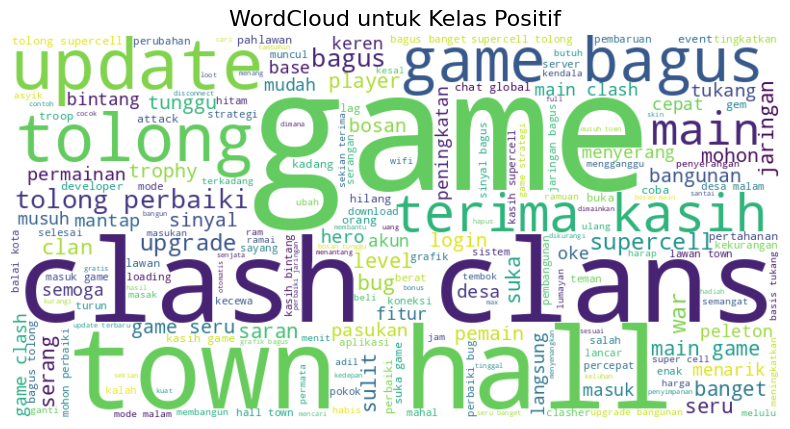

In [17]:
# Wordcloud kelas positif
generate_wordcloud(positive_reviews, "Positif")

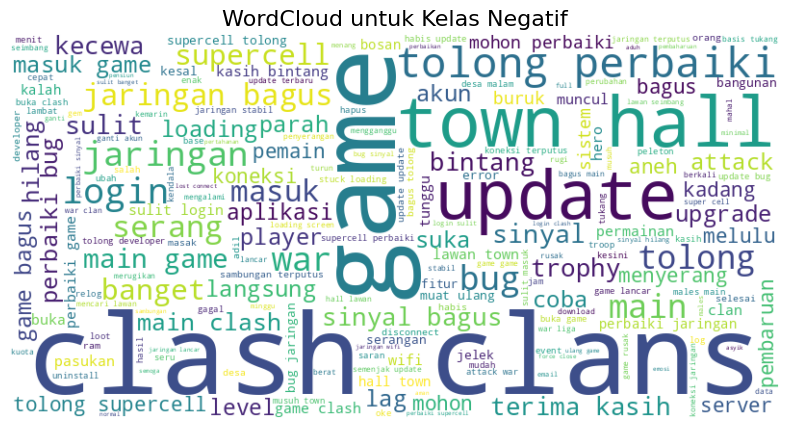

In [18]:
# Wordcloud kelas negatif
generate_wordcloud(negative_reviews, "Negatif")

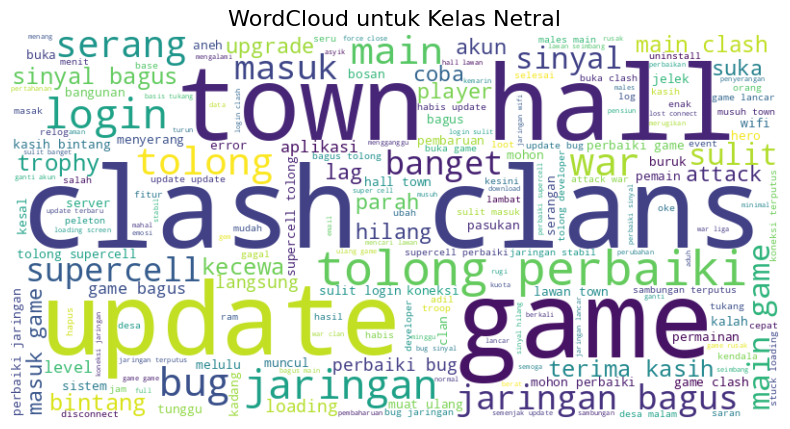

In [19]:
# Wordcloud kelas negatif
generate_wordcloud(negative_reviews, "Netral")

<ipython-input-20-679ec4a7b9d1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_cleaned, x='label', palette='Set2')


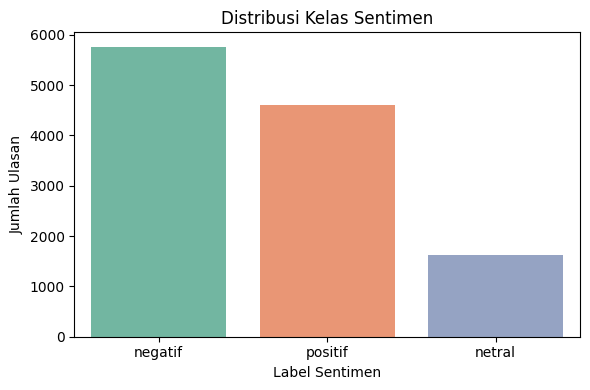

In [20]:
# Plot distribusi label sentimen
plt.figure(figsize=(6,4))
sns.countplot(data=df_cleaned, x='label', palette='Set2')
plt.title('Distribusi Kelas Sentimen')
plt.xlabel('Label Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.tight_layout()
plt.show()

Karena distribusi kelas tidak seimbang (*imbalanced*), maka akan dilakukan resampling menggunakan SMOTE.

## Training and Testing Model

In [21]:
# Set seed agar hasil reproducible
SEED = 0
np.random.seed(SEED)
random.seed(SEED)


### Skenario 1:
- Algoritma: Random Forest
- Ekstraksi Fitur: TF-IDF
- Pembagian Data: 80/20

In [22]:
# Pisahkan fitur (X) dan target (y)
X_1 = df_cleaned['text_final']
y_1 = df_cleaned['label']

# Encode label menjadi numerik
le_1 = LabelEncoder()
y_encoded_1 = le_1.fit_transform(y_1)

# Menampilkan mapping antara label asli dan label numerik
print("Mapping label:")
for label, kode in zip(le_1.classes_, range(len(le_1.classes_))):
    print(f"{kode} -> {label}")

Mapping label:
0 -> negatif
1 -> netral
2 -> positif


In [23]:
# Inisialisasi TF-IDF
tfidf_1 = TfidfVectorizer(
    max_features=80000,
    ngram_range=(1,2),
    sublinear_tf=True,
    min_df=3,
    max_df=0.98
)

# Fit TF-IDF
X_tfidf_1 = tfidf_1.fit_transform(X_1)

# Oversampling menggunakan SMOTE
smote = SMOTE(sampling_strategy={1: 5600, 2: 5600}, random_state=SEED)
X_resampled_1, y_resampled_1 = smote.fit_resample(X_tfidf_1, y_encoded_1)

# Split data ke training dan testing
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_resampled_1, y_resampled_1, test_size=0.2, random_state=SEED)

<ipython-input-24-3b0b37a4925c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_resampled, x='label_name', palette='Set2')


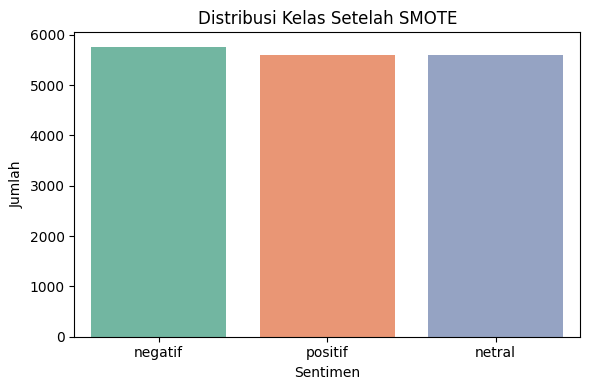

In [24]:
# Ubah hasil resample ke DataFrame
df_resampled = pd.DataFrame({'text': X_resampled_1, 'label': y_resampled_1})
df_resampled['label_name'] = le_1.inverse_transform(df_resampled['label'])

# Visualisasi countplot
plt.figure(figsize=(6,4))
sns.countplot(data=df_resampled, x='label_name', palette='Set2')
plt.title("Distribusi Kelas Setelah SMOTE")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

In [25]:
# Random Forest
rf_1 = RandomForestClassifier(n_estimators=950, max_features='log2', criterion='gini', random_state=SEED)
rf_1.fit(X_train_1.toarray(), y_train_1)

# Prediksi
y_pred_train_rf_1 = rf_1.predict(X_train_1.toarray())
y_pred_test_rf_1 = rf_1.predict(X_test_1.toarray())

# Evaluasi
print("=== Random Forest ===")
print(f"Akurasi Train : {accuracy_score(y_train_1, y_pred_train_rf_1):.4f}")
print(f"Akurasi Test  : {accuracy_score(y_test_1, y_pred_test_rf_1):.4f}")
print("\nClassification Report (Test Data):")
print(classification_report(y_test_1, y_pred_test_rf_1))

=== Random Forest ===
Akurasi Train : 0.9982
Akurasi Test  : 0.8323

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      1129
           1       0.97      0.87      0.92      1150
           2       0.79      0.80      0.79      1113

    accuracy                           0.83      3392
   macro avg       0.84      0.83      0.83      3392
weighted avg       0.84      0.83      0.83      3392



### Skenario 2:
- Algoritma: Random Forest
- Ekstraksi Fitur: TF-IDF
- Pembagian Data: 90/10

In [26]:
# Pisahkan fitur (X) dan target (y)
X_2 = df_cleaned['text_final']
y_2 = df_cleaned['label']

# Encode label menjadi numerik
le_2 = LabelEncoder()
y_encoded_2 = le_2.fit_transform(y_2)

# Menampilkan mapping antara label asli dan label numerik
print("Mapping label:")
for label, kode in zip(le_2.classes_, range(len(le_2.classes_))):
    print(f"{kode} -> {label}")

Mapping label:
0 -> negatif
1 -> netral
2 -> positif


In [27]:
# Inisialisasi TF-IDF
tfidf_2 = TfidfVectorizer(
    max_features=80000,
    ngram_range=(1,2),
    sublinear_tf=True,
    min_df=3,
    max_df=0.97
)

# Fit TF-IDF
X_tfidf_2 = tfidf_2.fit_transform(X_2)

# Oversampling menggunakan SMOTE
smote = SMOTE(sampling_strategy={1: 5600, 2: 5600}, random_state=SEED)
X_resampled_2, y_resampled_2 = smote.fit_resample(X_tfidf_2, y_encoded_2)

# Split data ke training dan testing
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_resampled_2, y_resampled_2, test_size=0.1, random_state=SEED)

<ipython-input-28-55b492c3a552>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_resampled, x='label_name', palette='Set2')


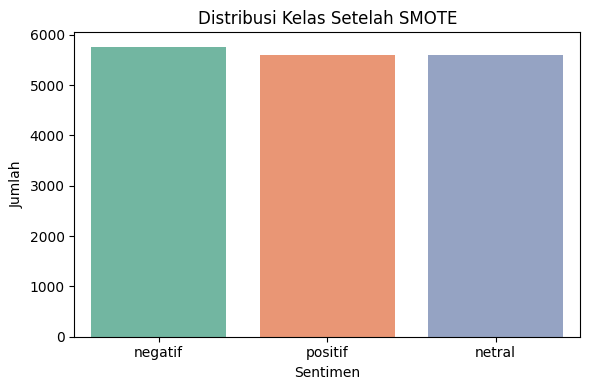

In [28]:
# Ubah hasil resample ke DataFrame
df_resampled = pd.DataFrame({'text': X_resampled_2, 'label': y_resampled_2})
df_resampled['label_name'] = le_2.inverse_transform(df_resampled['label'])

# Visualisasi countplot
plt.figure(figsize=(6,4))
sns.countplot(data=df_resampled, x='label_name', palette='Set2')
plt.title("Distribusi Kelas Setelah SMOTE")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

In [30]:
# Random Forest
rf_2 = RandomForestClassifier(n_estimators=950, max_features='log2', criterion='entropy', random_state=SEED)
rf_2.fit(X_train_2.toarray(), y_train_2)

# Prediksi
y_pred_train_rf_2 = rf_2.predict(X_train_2.toarray())
y_pred_test_rf_2 = rf_2.predict(X_test_2.toarray())

# Evaluasi
print("=== Random Forest ===")
print(f"Akurasi Train : {accuracy_score(y_train_2, y_pred_train_rf_2):.4f}")
print(f"Akurasi Test  : {accuracy_score(y_test_2, y_pred_test_rf_2):.4f}")
print("\nClassification Report (Test Data):")
print(classification_report(y_test_2, y_pred_test_rf_2))

=== Random Forest ===
Akurasi Train : 0.9981
Akurasi Test  : 0.8508

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       550
           1       0.97      0.89      0.93       576
           2       0.83      0.81      0.82       570

    accuracy                           0.85      1696
   macro avg       0.86      0.85      0.85      1696
weighted avg       0.86      0.85      0.85      1696



### Skenario 3:
- Algoritma: Naive Bayes
- Ekstraksi Fitur: CountVectorizer
- Pembagian Data: 70/30

In [31]:
# Pisahkan fitur (X) dan target (y)
X_3 = df_cleaned['text_final']
y_3 = df_cleaned['label']

# Encode label menjadi numerik
le_3 = LabelEncoder()
y_encoded_3 = le_3.fit_transform(y_3)

# Menampilkan mapping antara label asli dan label numerik
print("Mapping label:")
for label, kode in zip(le_3.classes_, range(len(le_3.classes_))):
    print(f"{kode} -> {label}")

Mapping label:
0 -> negatif
1 -> netral
2 -> positif


In [32]:
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=3, max_df=0.97, max_features=80000)
X_countVectorizer = vectorizer.fit_transform(X_3)

# Oversampling menggunakan SMOTE
smote = SMOTE(sampling_strategy={1: 5600, 2:5600}, random_state=SEED)
X_resampled_3, y_resampled_3 = smote.fit_resample(X_countVectorizer, y_encoded_3)

# Split data ke training dan testing
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_resampled_3, y_resampled_3, test_size=0.3, random_state=SEED)

<ipython-input-33-ef6ff71a39b7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_resampled, x='label_name', palette='Set2')


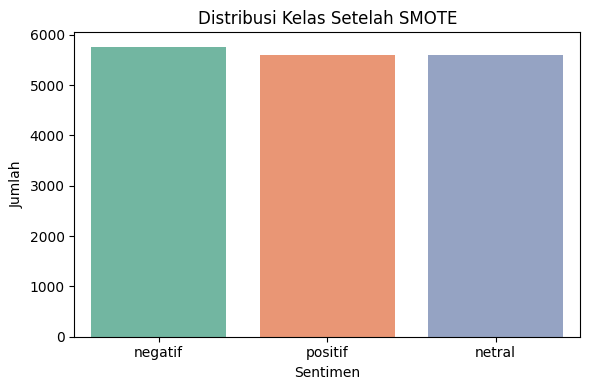

In [33]:
# Ubah hasil resample ke DataFrame
df_resampled = pd.DataFrame({'text': X_resampled_3, 'label': y_resampled_3})
df_resampled['label_name'] = le_3.inverse_transform(df_resampled['label'])

# Visualisasi countplot
plt.figure(figsize=(6,4))
sns.countplot(data=df_resampled, x='label_name', palette='Set2')
plt.title("Distribusi Kelas Setelah SMOTE")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

In [34]:
# Naïve Bayes
nb = MultinomialNB()
nb.fit(X_train_3.toarray(), y_train_3)

# Prediksi
y_pred_train_nb = nb.predict(X_train_3.toarray())
y_pred_test_nb = nb.predict(X_test_3.toarray())

# Evaluasi
print("=== Naïve Bayes ===")
print(f"Akurasi Train : {accuracy_score(y_train_3, y_pred_train_nb):.4f}")
print(f"Akurasi Test  : {accuracy_score(y_test_3, y_pred_test_nb):.4f}")
print("\nClassification Report (Test Data):")
print(classification_report(y_test_3, y_pred_test_nb))

=== Naïve Bayes ===
Akurasi Train : 0.6940
Akurasi Test  : 0.6016

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.56      0.71      0.62      1694
           1       0.59      0.45      0.51      1691
           2       0.67      0.65      0.66      1703

    accuracy                           0.60      5088
   macro avg       0.61      0.60      0.60      5088
weighted avg       0.61      0.60      0.60      5088



Berdasarkan tiga skenario yang telah diuji, model terbaik diperoleh pada skenario kedua. Model ini menggunakan algoritma **Random Forest**, dengan **TF-IDF** sebagai vectorizer, serta skema pembagian dataset **90% data latih dan 10% data uji**. Hasilnya menunjukkan akurasi **99% pada training set dan 85% pada testing set**, menjadikannya pilihan yang paling optimal dalam eksperimen ini.

In [55]:
# Simpan model
with open("random_forest_model_2.pkl", "wb") as file:
    pickle.dump(rf_2, file)

# Simpan vectorizer
with open("tfidf_vectorizer_2.pkl", "wb") as file:
    pickle.dump(tfidf_2, file)

# Simpan label encoder
with open("label_encoder_2.pkl", "wb") as file:
    pickle.dump(le_2, file)

## Inference/Testing pada Data Baru

In [59]:
# Inference langsung di notebook (dengan model & vectorizer yang sudah diload)
text_input = [
    "game clash of clans beneran terbaik hingga saat ini",
    "update bug biar war aman",
    "game ampas, update melulu anjing!!"
]

# Transform input
X_input = tfidf_2.transform(text_input)

# Prediksi
predicted_labels = rf_2.predict(X_input)

# Decode label numerik ke label asli
decoded_labels = le_2.inverse_transform(predicted_labels)

# Print hasil prediksi
for text, label in zip(text_input, decoded_labels):
    print(f"Review: {text} -> Sentimen: {label}")

Review: game clash of clans beneran terbaik hingga saat ini -> Sentimen: positif
Review: update bug biar war aman -> Sentimen: netral
Review: game ampas, update melulu anjing!! -> Sentimen: negatif
